# Calculating transformations between images

In which we discover optimization and cost functions and how to use them.

For this notebook you will need:

* [ds114 FMRI image]({{ site.url }}{{ site.baseurl }}/data/ds114_sub009_t2r1.nii)

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
# Print numbers to 4 digits precision
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
# Set some plot defaults
plt.rcParams['image.cmap'] = 'gray'

We start with a single slice from the EPI

In [3]:
import nibabel as nib

We load the data and drop the first volume (we found earlier that it is bad):

In [4]:
# Load the image
bold_fname = 'ds114_sub009_t2r1.nii'
bold_img = nib.load(bold_fname)
# Load the data as a 4D array
bold_data = bold_img.get_fdata()
bold_data.shape

(64, 64, 30, 173)

Drop the first volume:

In [5]:
bold_data = bold_data[:, :, :, 1:]
bold_data.shape

(64, 64, 30, 172)

Now we get our slices.  Here I am getting slice 17 from the first volume:

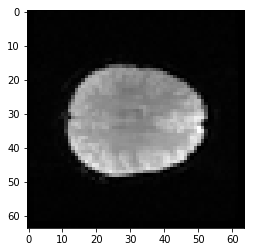

In [6]:
mid_vol0 = bold_data[:, :, 17, 0]
plt.imshow(mid_vol0)

Let's pretend we are doing motion correction.  We want to match this slice in volume 0 to the same slice in volume 1.

Here is the matching slice from the second volume:

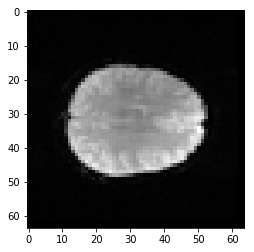

In [7]:
mid_vol1 = bold_data[:, :, 17, 1]
plt.imshow(mid_vol1)

At the moment it is rather hard to see any difference between these two.  That is still true even if we put the slices side by side:

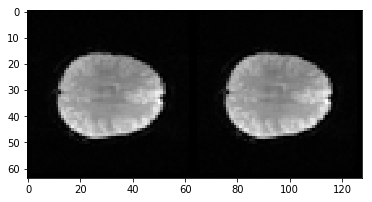

In [8]:
plt.imshow(np.hstack((mid_vol0, mid_vol1)))

The volumes are very similar, because the movement between them is very small - usually considerably less than a single voxel.  So, in order to find the movement between them, we will have to do an automated calculation.

To see how an automated calculation might work, let's push ``mid_vol1`` 10 voxels down, and then try and match this version to ``mid_vol0``:

In [9]:
moved_mid_vol1 = np.zeros_like(mid_vol1)
moved_mid_vol1.shape

(64, 64)

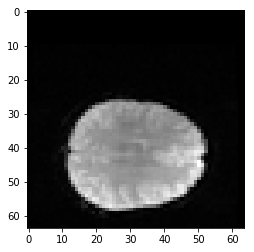

In [10]:
moved_mid_vol1[10:, :] = mid_vol1[:-10, :]
plt.imshow(moved_mid_vol1)

Let's say you didn't know how many voxels the image was translated.  You might want a good way to find out. How are we going to do that?

We need to try moving one image (``moved_mid_vol1``) to match our first image.  Then we need some way of knowing if our moved image is close to our first image or not.

Don't worry about the details of this function, but it moves the image up and down by a given number of voxels, in the same way we did this above:

In [11]:
def x_trans_slice(img_slice, x_vox_trans):
    """ Make a new copy of `img_slice` translated by `x_vox_trans` voxels
    
    `x_vox_trans` can be positive or negative
    """
    trans_slice = np.zeros_like(img_slice)
    if x_vox_trans < 0:
        trans_slice[:x_vox_trans, :] = img_slice[-x_vox_trans:, :]
    elif x_vox_trans == 0:
        trans_slice[:, :] = img_slice
    else:
        trans_slice[x_vox_trans:, :] = img_slice[:-x_vox_trans, :]
    return trans_slice

Now we need some measure of whether the images are the same or different.  This is called a *cost function*.  The measure is high when the images are different, and low when they are similar.

How about subtracting the images?

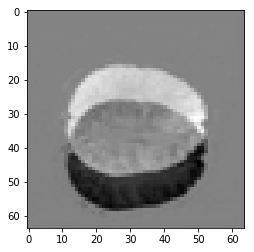

In [12]:
plt.imshow(mid_vol0 - moved_mid_vol1)

Can we take the sum of this difference?

No, because the negative numbers (black) will cancel out the positive numbers (white).  We need something better:

In [13]:
def mean_abs_cost(slice0, slice1):
    """ Calculate a measure of similarity between two image slices
    """
    return np.mean(np.abs(slice0 - slice1))

Now we can check different values of translation with our cost function.  We move the image up and down and recalculate the cost function for every candidate translation in x.

This is what makes it a *cost function*.  The cost function gives us the cost *as a function of* some transformation, here a translation in x:

In [14]:
costs = []
translations = range(-25, 15)
for t in translations:
    unmoved = x_trans_slice(moved_mid_vol1, t)
    cost = mean_abs_cost(unmoved, mid_vol0)
    costs.append(cost)

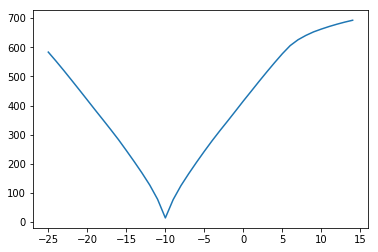

In [15]:
plt.plot(translations, costs)

We can try other cost functions.  Another measure of how well the images match might be the correlation of the voxel values at each voxel:

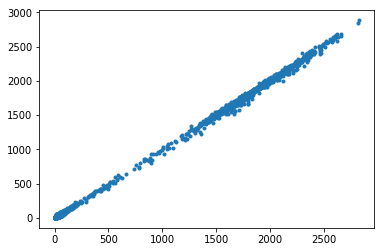

In [16]:
n_voxels = np.prod(mid_vol1.shape)
mid_vol0_as_1d = mid_vol0.reshape(n_voxels)
mid_vol1_as_1d = mid_vol1.reshape(n_voxels)
plt.plot(mid_vol1_as_1d, mid_vol0_as_1d, '.')

We expect that the correlation will be high and positive when the images are well matched.  Our cost function should be low when the images are well-matched, so we can take the negative correlation:

In [17]:
def correl_cost(slice0, slice1):
    """ Negative correlation between the two images, flattened to 1D """
    correl = np.corrcoef(slice0.ravel(), slice1.ravel())[0, 1]
    return -correl

In [18]:
correl_costs = []
translations = range(-25, 15)
for t in translations:
    unmoved = x_trans_slice(moved_mid_vol1, t)
    cost = correl_cost(unmoved, mid_vol0)
    correl_costs.append(cost)

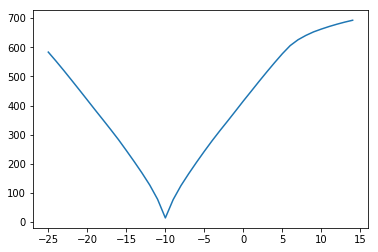

In [19]:
plt.plot(translations, costs)

So far we have only tried translations by exactly one voxel.

How about non-integer translations?  Will these work?

To do a non-integer translation, we have to think more generally about how to make an image that matches another image, after a transformation.

## Resampling in 2D

We need a more general reampling algorithm.  This is like the interpolation we do for slice timing, but in two dimensions.

Let's say we want to do a voxel translation of 0.5 voxels in X.  The way we might go about this is the following.

To start, here are some names:

* `img0` is the image we are trying to match to (in our case `mid_vol0`);
* `img1` is the image we are trying to match by moving (in our case `moved_mid_vol1`);
* `trans` the transformation from pixel coordinates in `img1` to pixel coordinates in `img0` (in our case adding 0.5 to the first coordinate value, so that [0, 0] becomes [0.5, 0]);
* `itrans` is the inverse of `trans`, and gives the transformation to go from pixel coordinates in `img0` to pixel coordinates in `img1`.  In our case this is subtracting 0.5 from the first coordinate value.

The procedure for resampling is:

* Make a 2D image the same shape as the image we want to match to (`img0`) - call this `new_img0`;
* For each pixel in `new_img0`;
    * We will name the pixel coordinate for this pixel `coord_for_img0`;
    * transform `coord_for_img0` using `itrans`.  In our case this would be to subtract 0.5 from the first coordinate value ([0, 0] becomes [-0.5, 0]).  Call the transformed coordinate `coord_for_img1`;
    * Estimate the pixel value in `img1` at coordinate `coord_for_img1`. Call this value `img1_value_estimate`;
    * Insert `img1_value` into `new_img0` at coordinate `coord_for_img0`.
    
The "Estimate pixel value" step is called *resampling*.  As you can see this is the same general idea as interpolating in one dimension, as for slice timing.  There are various ways of interpolating in two or three dimensions, but one of the most obvious is the simple extension of linear interpolation to two (or more) dimensions - [bilinear interpolation](http://en.wikipedia.org/wiki/Bilinear_interpolation).

The `scipy.ndimage` library has routines for resampling in 2 or 3 dimensions:

In [20]:
import scipy.ndimage as snd

In fact the ``affine_transform`` function from `scipy.ndimage` will do the whole process for us:

In [21]:
def fancy_x_trans_slice(img_slice, x_vox_trans):
    """ Make a new copy of `img_slice` translated by `x_vox_trans` voxels
    
    `x_vox_trans` can be positive or negative, and can be a float.
    """
    trans_slice = snd.affine_transform(img_slice, 
                                       np.eye(2),  # identity rotation, zooms
                                       [-x_vox_trans, 0])
    return trans_slice

In [22]:
fine_costs = []
fine_translations = np.linspace(-25, 15, 100)
for t in fine_translations:
    unmoved = fancy_x_trans_slice(moved_mid_vol1, t)
    cost = correl_cost(unmoved, mid_vol0)
    fine_costs.append(cost)

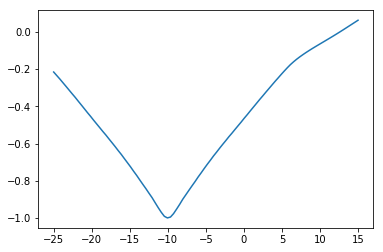

In [23]:
plt.plot(fine_translations, fine_costs)

We are looking for the best x translation.  At the moment we have to sample lots of x translations and then choose the best.  Is there a better way?

## Optimization

*Optimization* is a field of mathematics / computer science that solves this exact problem:

http://en.wikipedia.org/wiki/Mathematical_optimization

There are many optimization routines in Python, MATLAB and other languages.  These routines typically allow you to pass some function, and the routine returns the parameters of the function that give the lowest value.

In our case, we will need to feed the program the cost function, which accepts one parameter (the x translation value), and which returns our cost function value for that translation.

The optimization works by running the function at different values of the parameter (in our case, x translation), and using an algorithm to choose the next value of the parameter to try.  When it finds a parameter value for which very small changes up or down only increase the function value, the routine stops and returns the parameter value.

We'll use the fact that Python functions pick up variables defined in the global scope:

In [24]:
def cost_function(x_trans):
    # Function can see and use the image slices defined 
    # in the global (notebook) scope
    unmoved = fancy_x_trans_slice(moved_mid_vol1, x_trans)
    return correl_cost(unmoved, mid_vol0)

In [25]:
# value of the negative correlation for no translatino
cost_function(0)

-0.46640063188471781

In [26]:
# value of the negative correlation for translation of -10 voxels
cost_function(-10)

-0.99967828767663958

Now we get a general optimizing routine from the `scipy` Python library.  `fmin` finds the minimum of a function:

In [27]:
from scipy.optimize import fmin

We pass the ``fmin`` routine our Python function, and a starting value of zero for the translation:

In [28]:
fmin(cost_function, [0])

Optimization terminated successfully.
         Current function value: -0.999681
         Iterations: 31
         Function evaluations: 62


array([-9.9923])

The function ran, and found that a translation of very nearly -10 gave the smallest value for our cost function.

What actually happened there?  Let's track the progress using a callback function:

In [29]:
def my_callback(params):
   print("Trying parameters " + str(params))

In [30]:
fmin(cost_function, [0], callback=my_callback)

Trying parameters [-0.0005]
Trying parameters [-0.0015]
Trying parameters [-0.0035]
Trying parameters [-0.0075]
Trying parameters [-0.0155]
Trying parameters [-0.0315]
Trying parameters [-0.0635]
Trying parameters [-0.1275]
Trying parameters [-0.2555]
Trying parameters [-0.5115]
Trying parameters [-1.0235]
Trying parameters [-2.0475]
Trying parameters [-4.0955]
Trying parameters [-8.1915]
Trying parameters [-10.2395]
Trying parameters [-10.2395]
Trying parameters [-10.2395]
Trying parameters [-9.9835]
Trying parameters [-9.9835]
Trying parameters [-9.9835]
Trying parameters [-9.9835]
Trying parameters [-9.9995]
Trying parameters [-9.9915]
Trying parameters [-9.9915]
Trying parameters [-9.9915]
Trying parameters [-9.9925]
Trying parameters [-9.9925]
Trying parameters [-9.9923]
Trying parameters [-9.9924]
Trying parameters [-9.9923]
Optimization terminated successfully.
         Current function value: -0.999681
         Iterations: 31
         Function evaluations: 62


array([-9.9923])

The optimization routine `fmin` is trying various different translations, starting at 0, then going past -10, finally coming back to the optimimum (minimum) translation of very nearly -10.

## More than one parameter

How about adding y translation as well?

Our optimization routine can deal with this in a very simple way.  It does this:

* Adjusts the x translation until it has reached a minimum, then;
* Adjusts the y translation until it has reached a minimum, then;
* Repeat x, y minimization until the minimum for both is stable.

In [31]:
def fancy_xy_trans_slice(img_slice, x_y_trans):
    """ Make a new copy of `img_slice` translated by `x_y_trans` voxels
    
    x_y_trans is a sequence or array length 2, containing the (x, y) translations in voxels.
    
    Values in `x_y_trans` can be positive or negative, and can be floats.
    """
    x_y_trans = np.array(x_y_trans)
    trans_slice = snd.affine_transform(img_slice,
                                       np.eye(2),
                                       -x_y_trans)
    return trans_slice

In [32]:
def fancy_cost_at_xy(x_y_trans):
    """ Give cost function at xy translation values `x_y_trans`
    """
    unmoved = fancy_xy_trans_slice(moved_mid_vol1, x_y_trans)
    return correl_cost(unmoved, mid_vol0)

In [33]:
fmin(fancy_cost_at_xy, [0, 0], callback=my_callback)

Trying parameters [-0.0005  0.0004]
Trying parameters [-0.0008  0.0001]
Trying parameters [-0.0019  0.0007]
Trying parameters [-0.0029  0.0003]
Trying parameters [-0.0057  0.0014]
Trying parameters [-0.0092  0.0012]
Trying parameters [-0.0166  0.0032]
Trying parameters [-0.0272  0.0039]
Trying parameters [-0.0472  0.0082]
Trying parameters [-0.0786  0.0117]
Trying parameters [-0.1343  0.0221]
Trying parameters [-0.2249  0.0344]
Trying parameters [-0.3815  0.0612]
Trying parameters [-0.6409  0.0992]
Trying parameters [-1.0839  0.172 ]
Trying parameters [-1.8243  0.2843]
Trying parameters [-3.0804  0.486 ]
Trying parameters [-5.1894  0.8116]
Trying parameters [-8.7561  1.3777]
Trying parameters [-10.865    1.7032]
Trying parameters [-10.865    1.7032]
Trying parameters [-10.865    1.7032]
Trying parameters [-9.8357  1.5453]
Trying parameters [-9.8357  1.5453]
Trying parameters [-9.8357  1.5453]
Trying parameters [-9.8357  1.5453]
Trying parameters [-9.9203  1.5566]
Trying parameters [-9.

array([-9.9925,  0.008 ])

## Full 3D estimate

Now we know how to do two parameters, it's easy to extend this to six parameters.

The six parameters are:

* x translation
* y translation
* z translation
* rotation around x axis (pitch)
* rotation around y axis (roll)
* rotation around z axis (yaw)

Any transformation with these parameters is called a *rigid body* transformation because the transformation cannot make the object change shape (the object is *rigid*).

Implementing the rotations is just slightly out of scope for this tutorial (we would have to convert between angles and [rotation matrices](http://en.wikipedia.org/wiki/Rotation_matrix)), so here is the 3D optimization with the three translation parameters:

First we get our volumes to match:

In [34]:
vol0 = bold_data[:, :, :, 0]
vol1 = bold_data[:, :, :, 1]

To make it a bit more interesting, shift the second volume 10 voxels on the first axis, as we did for the 2D case:

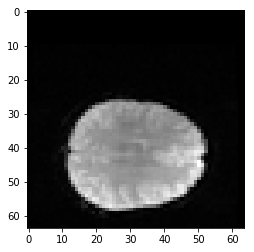

In [35]:
shifted_vol1 = vol1 * 0
shifted_vol1[10:, :, :] = vol1[:-10, :, :]
plt.imshow(shifted_vol1[:, :, 17])

We define resampling for any given x, y, z translation:

In [36]:
def xyz_trans_vol(vol, x_y_z_trans):
    """ Make a new copy of `vol` translated by `x_y_z_trans` voxels
    
    x_y_z_trans is a sequence or array length 3, containing the (x, y, z) translations in voxels.
    
    Values in `x_y_z_trans` can be positive or negative, and can be floats.
    """
    x_y_z_trans = np.array(x_y_z_trans)
    # [1, 1, 1] says to do no zooming or rotation
    trans_vol = snd.affine_transform(vol, np.eye(3), -x_y_z_trans)
    return trans_vol

Our cost function (picking up `vol0`, `shifted_vol1` from the global namespace):

In [37]:
def cost_at_xyz(x_y_z_trans):
    """ Give cost function value at xyz translation values `x_y_z_trans`
    """
    unmoved = xyz_trans_vol(shifted_vol1, x_y_z_trans)
    return correl_cost(unmoved, vol0)

In [38]:
fmin(cost_at_xyz, [0, 0, 0], callback=my_callback)

Trying parameters [ 0.0002  0.0002 -0.0003]
Trying parameters [-0.0003  0.0004 -0.0003]
Trying parameters [-0.0003  0.0004 -0.0003]
Trying parameters [-0.0003  0.0004 -0.0003]
Trying parameters [-0.001   0.0011 -0.0006]
Trying parameters [-0.001   0.0011 -0.0006]
Trying parameters [-0.0018  0.0014 -0.0004]
Trying parameters [-0.003   0.0025 -0.0012]
Trying parameters [-0.003   0.0025 -0.0012]
Trying parameters [-0.0058  0.0041 -0.0012]
Trying parameters [-0.0081  0.0064 -0.0024]
Trying parameters [-0.011  0.008 -0.003]
Trying parameters [-0.019   0.0135 -0.0042]
Trying parameters [-0.0265  0.0197 -0.0072]
Trying parameters [-0.0402  0.0284 -0.0097]
Trying parameters [-0.0637  0.0456 -0.0151]
Trying parameters [-0.0925  0.0666 -0.0236]
Trying parameters [-0.1434  0.1011 -0.0339]
Trying parameters [-0.2191  0.1566 -0.0533]
Trying parameters [-0.3275  0.2332 -0.0806]
Trying parameters [-0.5051  0.3577 -0.1205]
Trying parameters [-0.765   0.5451 -0.1866]
Trying parameters [-1.1594  0.8229 

array([-9.9925, -0.0056, -0.0025])